In [ ]:
import gzip
import json
import nltk
import string
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.constraints import unit_norm
from datetime import datetime
drive.mount('/content/gdrive')
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

Mounted at /content/gdrive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
%load_ext tensorboard

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Amazon_Review_5.json.gz

--2021-12-01 07:35:24--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Amazon_Review_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25270692239 (24G) [application/octet-stream]
Saving to: ‘All_Amazon_Review_5.json.gz’

All_Amazon_Review_5 100%[===================>]  23.54G  53.7MB/s    in 8m 17s  

2021-12-01 07:43:41 (48.5 MB/s) - ‘All_Amazon_Review_5.json.gz’ saved [25270692239/25270692239]



In [ ]:
balanced_data = []
with gzip.open('All_Amazon_Review_5.json.gz') as f:
    pos_limit = 500000
    neg_limit = 500000
    for l in f:
        #Using first 1M records. All records used up all the RAM. 
        if pos_limit == 0 and neg_limit == 0:
          break
        json_data = json.loads(l.strip())
        overall = json_data['overall']
        if 'reviewText' not in json_data:
          continue
        if overall < 4.0 and neg_limit > 0: 
          balanced_data.append(json_data)
          neg_limit -= 1
        elif overall >= 4.0 and pos_limit > 0:
          balanced_data.append(json_data)
          pos_limit -= 1

In [ ]:
balanced_df = pd.DataFrame.from_dict(balanced_data)
b_sentiment_df = pd.concat([balanced_df['unixReviewTime'], balanced_df['reviewText'], balanced_df['overall']], axis=1)
b_sentiment_df['sentiment'] = np.where(b_sentiment_df['overall'] < 4.0, 0, 1)
b_sentiment_df['datetimeReviewTime'] = pd.to_datetime(b_sentiment_df['unixReviewTime'], unit='s')
b_sentiment_df['reviewText'] = np.where(pd.isnull(b_sentiment_df['reviewText']), b_sentiment_df['reviewText'], b_sentiment_df['reviewText'].astype(str))
print(len(b_sentiment_df))

1000000


In [ ]:

df_13 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2013-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2014-01-01')]
df_14 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2014-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2015-01-01')]
df_15 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2015-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2016-01-01')]
df_16 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2016-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2017-01-01')]
df_17 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2017-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2018-01-01')]
df_18 = b_sentiment_df[(b_sentiment_df['datetimeReviewTime'] >= '2018-01-01') & (b_sentiment_df['datetimeReviewTime'] < '2019-01-01')]



sample_size = 10000

In [ ]:
df_total = pd.concat([df_13.sample(sample_size, random_state=123), df_14.sample(sample_size, random_state=123), df_15.sample(sample_size, random_state=123), df_16.sample(sample_size, random_state=123), df_17.sample(sample_size, random_state=123), df_18.sample(sample_size, random_state=123)]).dropna()
print(len(df_total))
train_data, test_data, train_sentiment, test_sentiment = train_test_split(df_total.drop('sentiment', axis=1), df_total['sentiment'], test_size=0.2, random_state=12345)

60000


In [ ]:
# print(np.mean(df_13['sentiment']))
# print(np.mean(df_14['sentiment']))
# print(np.mean(df_15['sentiment']))
# print(np.mean(df_16['sentiment']))
# print(np.mean(df_17['sentiment']))
# print(np.mean(df_18['sentiment']))

print(np.mean(df_total['sentiment']))

0.4989


Sentiment looks roughly balanced in each year. 

In [ ]:
all_train_text = train_data['reviewText']

vocab = Counter()
stop_words = set(nltk.corpus.stopwords.words('english'))
clean_text = []
for x in all_train_text:
  #unigrams
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]
  vocab.update(tokens)
  clean_text.append(tokens)
  
print(len(vocab))
print(vocab.most_common(10))

45229
[('one', 10622), ('like', 10081), ('great', 10058), ('use', 9371), ('', 9220), ('good', 8358), ('would', 8312), ('product', 7446), ('get', 7348), ('kindle', 6670)]


In [ ]:
min_occurance=2
tokens = [k for k,c in vocab.items() if c >= min_occurance]
print(len(tokens))
print(tokens[:10])
vocab = set(tokens)

21412
['tooooo', 'leathery', 'could', 'barely', 'chew', 'amazing', 'love', 'like', 'many', 'probably']


In [ ]:
filtered_text = []
for text in clean_text:
  text = [w for w in text if w in vocab]
  filtered_text.append(text)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_text)
encoded_text = tokenizer.texts_to_sequences(filtered_text)

In [ ]:
# # print(filtered_text[:3])
# # print(encoded_text[:3])

# for i in range(len(filtered_text)): 
#   text = filtered_text[i]
#   for j in range(len(text)):
#     word = text[j]
#     if word == 'works':
#       print("WORKS")
#       print(encoded_text[i][j])
#     # if word == 'nice':
#     #   print("NICE")
#     #   print(encoded_text[i][j]) 


In [ ]:
max_len = 80

In [ ]:
train_text = pad_sequences(encoded_text, maxlen=max_len, padding='post')
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

21413


In [ ]:
all_test_text = test_data['reviewText']
filtered_text_test = []
for x in all_test_text:
  #unigrams
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]

  #filter
  filtered_tokens = [w for w in tokens if w in vocab]
  
  filtered_text_test.append(filtered_tokens)


encoded_text_test = tokenizer.texts_to_sequences(filtered_text_test)
test_text = pad_sequences(encoded_text_test, maxlen=max_len, padding='post')

In [ ]:
# input = tf.keras.layers.Input(shape=(max_len,))
# embedding = Embedding(vocab_size, 100, input_length=max_len, name='embedding_layer')(input)
# conv_size_8 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_8', padding='same')(embedding)
# conv_size_4 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_4', padding='same')(embedding)
# conv_size_2 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_2', padding='same')(embedding)
# pooling_8 = MaxPooling1D(pool_size=max_len, name='pooling_8')(conv_size_8)
# pooling_4 = MaxPooling1D(pool_size=max_len, name='pooling_4')(conv_size_4)
# pooling_2 = MaxPooling1D(pool_size=max_len, name='pooling_2')(conv_size_2)
# concat = tf.keras.layers.concatenate([pooling_8, pooling_4, pooling_2], axis=2, name='concatenation')
# flatten = Flatten(name='flattening')(concat)
# dense = Dense(10, activation='relu', name='hidden_layer')(flatten)
# output = Dense(1, activation='sigmoid', name='output_layer')(dense)

# model_a = tf.keras.Model(inputs=input, outputs=output, name='Baseline_Model')
# print(model_a.summary())

In [ ]:
logdir="/content/gdrive/My Drive/large_CNN_imp_a/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_a.fit(train_text, train_sentiment, epochs=10, callbacks=[tensorboard_callback])
# model_a.save("/content/gdrive/My Drive/large_CNN_imp_a/model")

In [ ]:
# %tensorboard --logdir "/content/gdrive/My Drive/large_CNN_imp_a/logs/"

In [ ]:
model_loaded_a = tf.keras.models.load_model('/content/gdrive/My Drive/large_CNN_imp_a/model')
print(model_loaded_a.summary())
loss, accuracy = model_loaded_a.evaluate(test_text, test_sentiment)
print("Accuracy: " + str(accuracy*100))

Model: "Baseline_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 80, 100)      2141300     ['input_1[0][0]']                
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                     

### Add year to data

In [ ]:
for i, x in train_data.iterrows(): 
  training_string = str(x['datetimeReviewTime'].year) + ' ' +  x['reviewText']
  train_data.loc[i, 'text_with_year'] = training_string 

for i, x in test_data.iterrows(): 
  training_string = str(x['datetimeReviewTime'].year) + ' ' +  x['reviewText']
  test_data.loc[i, 'text_with_year'] = training_string 


In [ ]:
print(train_data.head()[['reviewText', 'text_with_year']])
print(test_data.head()[['reviewText', 'text_with_year']])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          reviewText                                                                                                                                                                                                                    

In [ ]:
all_train_text_year = train_data['text_with_year']

vocab_year = Counter()
stop_words = set(nltk.corpus.stopwords.words('english'))
clean_text_year = []
for x in all_train_text_year:
  #unigrams
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]
  vocab_year.update(tokens)
  clean_text_year.append(tokens)
  
print(len(vocab_year))
print(vocab_year.most_common(10))

min_occurance=2
tokens_year = [k for k,c in vocab_year.items() if c >= min_occurance]
print(len(tokens_year))
print(tokens_year[:10])
vocab_year = set(tokens_year)



filtered_text_year = []
for text in clean_text_year:
  text = [w for w in text if w in vocab_year]
  filtered_text_year.append(text)



tokenizer_year = Tokenizer()
tokenizer_year.fit_on_texts(filtered_text_year)
encoded_text_year = tokenizer_year.texts_to_sequences(filtered_text_year)

train_text_year = pad_sequences(encoded_text_year, maxlen=max_len, padding='post')

vocab_size_year = len(tokenizer_year.word_index) + 1
print(vocab_size_year)

45229
[('one', 10622), ('like', 10081), ('great', 10058), ('use', 9371), ('', 9220), ('good', 8358), ('would', 8312), ('2014', 8157), ('2017', 8104), ('2015', 8057)]
21412
['2018', 'tooooo', 'leathery', 'could', 'barely', 'chew', '2015', 'amazing', 'love', '2014']
21413


In [ ]:
all_test_text_year = test_data['text_with_year']
filtered_text_test_year = []
for x in all_test_text_year:
  #unigrams
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]

  #filter
  filtered_tokens = [w for w in tokens if w in vocab]
  
  filtered_text_test_year.append(filtered_tokens)


encoded_text_test_year = tokenizer_year.texts_to_sequences(filtered_text_test_year)
test_text_year = pad_sequences(encoded_text_test_year, maxlen=max_len, padding='post')

In [ ]:
# input = tf.keras.layers.Input(shape=(max_len,))
# embedding = Embedding(vocab_size_year, 100, input_length=max_len, name='embedding_layer')(input)
# conv_size_8 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_8', padding='same')(embedding)
# conv_size_4 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_4', padding='same')(embedding)
# conv_size_2 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_2', padding='same')(embedding)
# pooling_8 = MaxPooling1D(pool_size=max_len, name='pooling_8')(conv_size_8)
# pooling_4 = MaxPooling1D(pool_size=max_len, name='pooling_4')(conv_size_4)
# pooling_2 = MaxPooling1D(pool_size=max_len, name='pooling_2')(conv_size_2)
# concat = tf.keras.layers.concatenate([pooling_8, pooling_4, pooling_2], axis=2, name='concatenation')
# flatten = Flatten(name='flattening')(concat)
# dense = Dense(10, activation='relu', name='hidden_layer')(flatten)
# output = Dense(1, activation='sigmoid', name='output_layer')(dense)

# model_year_a = tf.keras.Model(inputs=input, outputs=output)
# print(model_year_a.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 80, 100)      2141300     ['input_2[0][0]']                
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                              

In [ ]:
logdir="/content/gdrive/My Drive/large_CNN_imp_year_a/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model_year_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_year_a.fit(train_text_year, train_sentiment, epochs=10, callbacks=[tensorboard_callback])
# model_year_a.save("/content/gdrive/My Drive/large_CNN_imp_year_a/model")

Epoch 1/10
1500/1500 [==============================] - 118s 78ms/step - loss: 0.3569 - accuracy: 0.8415
Epoch 2/10
1500/1500 [==============================] - 119s 79ms/step - loss: 0.2216 - accuracy: 0.9131
Epoch 3/10
1500/1500 [==============================] - 117s 78ms/step - loss: 0.1125 - accuracy: 0.9606
Epoch 4/10
1500/1500 [==============================] - 119s 79ms/step - loss: 0.0596 - accuracy: 0.9791
Epoch 5/10
1500/1500 [==============================] - 121s 80ms/step - loss: 0.0415 - accuracy: 0.9847
Epoch 6/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0361 - accuracy: 0.9863
Epoch 7/10
1500/1500 [==============================] - 118s 79ms/step - loss: 0.0340 - accuracy: 0.9869
Epoch 8/10
1500/1500 [==============================] - 121s 81ms/step - loss: 0.0324 - accuracy: 0.9875
Epoch 9/10
1500/1500 [==============================] - 122s 82ms/step - loss: 0.0305 - accuracy: 0.9879
Epoch 10/10
1500/1500 [==============================] 

In [ ]:
# %tensorboard --logdir "/content/gdrive/My Drive/large_CNN_imp_year_a/logs/"

In [ ]:
model_loaded_year_a = tf.keras.models.load_model('/content/gdrive/My Drive/large_CNN_imp_year_a/model')
print(model_loaded_year_a.summary())
loss, accuracy = model_loaded_year_a.evaluate(test_text_year, test_sentiment)
print("Accuracy: " + str(accuracy*100))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 80, 100)      2141300     ['input_2[0][0]']                
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer[0][0]']        
                                                                                              

In [ ]:
year_dict = {'2013': 0, '2014': 1, '2015': 2, '2016': 3, '2017': 4, '2018': 5}


for i, x in train_data.iterrows():
  train_data.loc[i, 'year'] = str(x['datetimeReviewTime'].year)



for i, x in test_data.iterrows():
  test_data['year'] = str(x['datetimeReviewTime'].year)


In [ ]:
year_tokenizer = Tokenizer()
year_tokenizer.fit_on_texts(['2013', '2014', '2015', '2016', '2017', '2018'])

encoded_year = year_tokenizer.texts_to_sequences(train_data['year'])
year_tokens = pad_sequences(encoded_year, maxlen=1)


test_encoded_year = year_tokenizer.texts_to_sequences(test_data['year'])
test_year_tokens = pad_sequences(test_encoded_year, maxlen=1)

In [ ]:
# input_text = tf.keras.layers.Input(shape=(max_len,))
# input_year = tf.keras.layers.Input(shape=(1,))
# embedding_text = Embedding(vocab_size, 100, input_length=max_len, name='embedding_layer_text')(input_text)
# embedding_year = Embedding(7, 96, name='embedding_layer_year')(input_year)
# conv_size_8 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_8', padding='same')(embedding_text)
# conv_size_4 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_4', padding='same')(embedding_text)
# conv_size_2 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_2', padding='same')(embedding_text)
# pooling_8 = MaxPooling1D(pool_size=max_len, name='pooling_8')(conv_size_8)
# pooling_4 = MaxPooling1D(pool_size=max_len, name='pooling_4')(conv_size_4)
# pooling_2 = MaxPooling1D(pool_size=max_len, name='pooling_2')(conv_size_2)
# concat = tf.keras.layers.concatenate([pooling_8, pooling_4, pooling_2], axis=2, name='concatenation')
# flatten_text = Flatten(name='flattening_text')(concat)
# flatten_year = Flatten(name='flattening_year')(embedding_year)
# concat_year = tf.keras.layers.concatenate([flatten_text, flatten_year], axis=1, name='join_year')
# dense = Dense(10, activation='relu', name='hidden_layer')(concat_year)
# output = Dense(1, activation='sigmoid', name='output_layer')(dense)

# model_year_concat = tf.keras.Model(inputs=[input_text, input_year], outputs=output)
# print(model_year_concat.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_layer_text (Embeddin  (None, 80, 100)     2141300     ['input_3[0][0]']                
 g)                                                                                               
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer_text[0][0]']   
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer_text[0][0

In [ ]:
logdir="/content/gdrive/My Drive/large_CNN_imp_year_concat/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model_year_concat.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_year_concat.fit([train_text, year_tokens], train_sentiment, epochs=10, callbacks=[tensorboard_callback])
# model_year_concat.save("/content/gdrive/My Drive/large_CNN_imp_year_concat/model")

Epoch 1/10
1500/1500 [==============================] - 134s 89ms/step - loss: 0.3643 - accuracy: 0.8355
Epoch 2/10
1500/1500 [==============================] - 123s 82ms/step - loss: 0.2255 - accuracy: 0.9108
Epoch 3/10
1500/1500 [==============================] - 124s 83ms/step - loss: 0.1161 - accuracy: 0.9596
Epoch 4/10
1500/1500 [==============================] - 126s 84ms/step - loss: 0.0599 - accuracy: 0.9790
Epoch 5/10
1500/1500 [==============================] - 125s 83ms/step - loss: 0.0423 - accuracy: 0.9846
Epoch 6/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0352 - accuracy: 0.9869
Epoch 7/10
1500/1500 [==============================] - 119s 79ms/step - loss: 0.0335 - accuracy: 0.9868
Epoch 8/10
1500/1500 [==============================] - 118s 79ms/step - loss: 0.0330 - accuracy: 0.9869
Epoch 9/10
1500/1500 [==============================] - 119s 79ms/step - loss: 0.0291 - accuracy: 0.9891
Epoch 10/10
1500/1500 [==============================] 

In [ ]:
# %tensorboard --logdir "/content/gdrive/My Drive/large_CNN_imp_year_concat/logs/"

In [ ]:
model_loaded_year_concat = tf.keras.models.load_model('/content/gdrive/My Drive/large_CNN_imp_year_concat/model')
loss, accuracy = model_loaded_year_concat.evaluate([test_text, test_year_tokens] , test_sentiment)
print("Accuracy: " + str(accuracy*100))

375/375 [==============================] - 5s 14ms/step - loss: 1.1180 - accuracy: 0.8335
Accuracy: 83.35000276565552


In [ ]:
# input_text = tf.keras.layers.Input(shape=(max_len,))
# input_year = tf.keras.layers.Input(shape=(1,))
# embedding_text = Embedding(vocab_size, 100, input_length=max_len, name='embedding_layer_text')(input_text)
# embedding_year = Embedding(7, 96, name='embedding_layer_year')(input_year)
# conv_size_8 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_8', padding='same')(embedding_text)
# conv_size_4 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_4', padding='same')(embedding_text)
# conv_size_2 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_2', padding='same')(embedding_text)
# pooling_8 = MaxPooling1D(pool_size=max_len, name='pooling_8')(conv_size_8)
# pooling_4 = MaxPooling1D(pool_size=max_len, name='pooling_4')(conv_size_4)
# pooling_2 = MaxPooling1D(pool_size=max_len, name='pooling_2')(conv_size_2)
# concat = tf.keras.layers.concatenate([pooling_8, pooling_4, pooling_2], axis=2, name='concatenation')
# flatten_text = Flatten(name='flattening_text')(concat)
# flatten_year = Flatten(name='flattening_year')(embedding_year)
# sum_year = tf.keras.layers.Add(name="summation_layer")([flatten_text, flatten_year])
# dense = Dense(10, activation='relu', name='hidden_layer')(sum_year)
# output = Dense(1, activation='sigmoid', name='output_layer')(dense)

# model_year_sum = tf.keras.Model(inputs=[input_text, input_year], outputs=output)
# print(model_year_sum.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_layer_text (Embeddin  (None, 80, 100)     2141300     ['input_5[0][0]']                
 g)                                                                                               
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer_text[0][0]']   
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding_layer_text[0][0

In [ ]:
logdir="/content/gdrive/My Drive/large_CNN_imp_year_sum/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model_year_sum.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_year_sum.fit([train_text, year_tokens], train_sentiment, epochs=10, callbacks=[tensorboard_callback])
# model_year_sum.save("/content/gdrive/My Drive/large_CNN_imp_year_sum/model")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
1500/1500 [==============================] - 121s 80ms/step - loss: 0.3646 - accuracy: 0.8385
Epoch 2/10
1500/1500 [==============================] - 123s 82ms/step - loss: 0.2286 - accuracy: 0.9099
Epoch 3/10
1500/1500 [==============================] - 123s 82ms/step - loss: 0.1186 - accuracy: 0.9585
Epoch 4/10
1500/1500 [==============================] - 121s 81ms/step - loss: 0.0637 - accuracy: 0.9776
Epoch 5/10
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0450 - accuracy: 0.9837
Epoch 6/10
1500/1500 [==============================] - 124s 83ms/step - loss: 0.0366 - accuracy: 0.9863
Epoch 7/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0339 - accuracy: 0.9869
Epoch 8/10
1500/1500 [==============================] - 121s 81ms/step - loss: 0.0315 - accuracy: 0.9877
Epoch 9/10
1500/1500 [==============================] - 122s 82ms/step - loss: 0.0326 - accuracy: 0.9874
Epoch 10/10
1500/1500 [==============================] 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# %tensorboard --logdir "/content/gdrive/My Drive/large_CNN_imp_year_sum/logs/"

In [ ]:
model_loaded_year_sum = tf.keras.models.load_model('/content/gdrive/My Drive/large_CNN_imp_year_sum/model')
loss, accuracy = model_loaded_year_sum.evaluate([test_text, test_year_tokens] , test_sentiment)
print("Accuracy: " + str(accuracy*100))

375/375 [==============================] - 5s 13ms/step - loss: 1.0345 - accuracy: 0.8392
Accuracy: 83.91666412353516


In [ ]:
probabilities = model_loaded_a.predict(test_text)
predictions = []
for p in probabilities:
  value = p[0]
  if value >= 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

probabilities_year = model_loaded_year_a.predict(test_text_year)
predictions_year = []
for p in probabilities_year:
  value = p[0]
  if value >= 0.5:
    predictions_year.append(1)
  else:
    predictions_year.append(0)

probabilities_year_concat = model_loaded_year_concat.predict([test_text, test_year_tokens])
predictions_year_concat = []
for p in probabilities_year_concat:
  value = p[0]
  if value >= 0.5:
    predictions_year_concat.append(1)
  else:
    predictions_year_concat.append(0)

probabilities_year_sum = model_loaded_year_concat.predict([test_text, test_year_tokens])
predictions_year_sum = []
for p in probabilities_year_sum:
  value = p[0]
  if value >= 0.5:
    predictions_year_sum.append(1)
  else:
    predictions_year_sum.append(0)



In [ ]:
sentiment_list = test_sentiment.to_list()
data_year = test_data['text_with_year'].to_list()
rating = test_data['overall'].to_list()


correct = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}
total = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

correct_year = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

correct_year_concat = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

correct_year_sum = {'2013': 0, '2014': 0, '2015': 0, '2016': 0, '2017': 0, '2018': 0}

false_positive = []
false_positive_year = []
false_positive_concat = []
false_positive_sum = []

false_negative = []
false_negative_year = []
false_negative_concat = []
false_negative_sum = []

for i in range(len(sentiment_list)):
  sent = sentiment_list[i]
  year = data_year[i].split()[0]

  if predictions[i] == sent: 
    correct[year] = correct[year] + 1
  else:
    if predictions[i] == 1:
      false_positive.append((data_year[i], rating[i]))
    else:
      false_negative.append((data_year[i], rating[i]))
  
  if predictions_year[i] == sent: 
    correct_year[year] = correct_year[year] + 1
  else:
    if predictions_year[i] == 1:
      false_positive_year.append((data_year[i], rating[i]))
    else:
      false_negative_year.append((data_year[i], rating[i]))
  
  if predictions_year_concat[i] == sent: 
    correct_year_concat[year] = correct_year_concat[year] + 1
  else:
    if predictions_year_concat[i] == 1:
      false_positive_concat.append((data_year[i], rating[i]))
    else:
      false_negative_concat.append((data_year[i], rating[i]))

  if predictions_year_sum[i] == sent: 
    correct_year_sum[year] = correct_year_sum[year] + 1
  else:
    if predictions_year_sum[i] == 1:
      false_positive_sum.append((data_year[i], rating[i]))
    else:
      false_negative_sum.append((data_year[i], rating[i]))
  
  total[year] = total[year] + 1

# print(correct)
# print(correct_year)
# print(correct_year_concat)
# print(correct_year_sum)
# print(total)


In [ ]:
prng = np.random.RandomState(123)

print("False Positive")

for i in range(10):
  index = prng.randint(0, len(false_positive))
  print(false_positive[index][0] + "|" + str(false_positive[index][1]))

print("False Negative")

for i in range(10):
  index = prng.randint(0, len(false_negative))
  print(false_negative[index][0] + "|" + str(false_negative[index][1]))



print("--------------")

print("False Positive")

for i in range(10):
  index = prng.randint(0, len(false_positive_year))
  print(false_positive_year[index][0] + "|" + str(false_positive_year[index][1]))

print("False Negative")

for i in range(10):
  index = prng.randint(0, len(false_negative_year))
  print(false_negative_year[index][0] + "|" + str(false_negative_year[index][1]))




print("--------------")

print("False Positive")

for i in range(10):
  index = prng.randint(0, len(false_positive_concat))
  print(false_positive_concat[index][0] + "|" + str(false_positive_concat[index][1]))

print("False Negative")

for i in range(10):
  index = prng.randint(0, len(false_negative_concat))
  print(false_negative_concat[index][0] + "|" + str(false_negative_concat[index][1]))

print("--------------")

print("False Positive")

for i in range(10):
  index = prng.randint(0, len(false_positive_sum))
  print(false_positive_sum[index][0] + "|" + str(false_positive_sum[index][1]))

print("False Negative")

for i in range(10):
  index = prng.randint(0, len(false_negative_sum))
  print(false_negative_sum[index][0] + "|" + str(false_negative_sum[index][1]))

False Positive
2018 Gave away as a gift. No thank you from our friends who we gave it to.|2.0
2016 Much too little for a small child. My mistake for not checking the measurements.  The sound is lovely and is works very well, just nit for a toddler.|3.0
2016 I've been using this daily, but so far have seen no difference in the appearance of my dark spot. If this changes by the time I finish the product, I will update my review.. hoping this is a matter of time and patience.|1.0
2017 Dimensions of buy fraction of a millimeter|1.0
2013 i bought this for a gift and the person was really happy. no complaints. good way to save some money too|3.0
2017 Works great but needs to  be a foot longer|3.0
2018 Not at all what I expected from the Braun name.  Causes Ingrown hairs and is not as efficient or easy to use|2.0
2017 It is sturdy and ruggedly built but it does not have a height adjustment for the microphone, which is a huge drawback. In hindsight, I would have done some more careful research

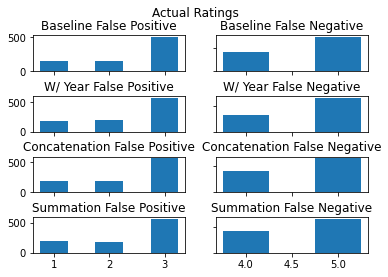

In [ ]:
fig, axes = plt.subplots(4,2)
fig.suptitle("Actual Ratings")
fig.subplots_adjust(hspace=0.7)

false_positive_values = []
for x in false_positive:
  false_positive_values.append(x[1])


axes[0, 0].hist(false_positive_values, bins=[0.5,1.5,2.5,3.5], rwidth=0.5)
axes[0,0].set_title("Baseline False Positive")


false_negative_values = []
for x in false_negative:
  false_negative_values.append(x[1])

axes[0, 1].hist(false_negative_values, bins=[3.5,4.5,5.5], rwidth=0.5)
axes[0,1].set_title("Baseline False Negative")

false_positive_values_year = []
for x in false_positive_year:
  false_positive_values_year.append(x[1])

axes[1, 0].hist(false_positive_values_year, bins=[0.5,1.5,2.5,3.5], rwidth=0.5)
axes[1,0].set_title("W/ Year False Positive")

false_negative_values_year = []
for x in false_negative_year:
  false_negative_values_year.append(x[1])

axes[1, 1].hist(false_negative_values_year, bins=[3.5,4.5,5.5], rwidth=0.5)
axes[1,1].set_title("W/ Year False Negative")


false_positive_values_concat = []
for x in false_positive_concat:
  false_positive_values_concat.append(x[1])

axes[2, 0].hist(false_positive_values_concat, bins=[0.5,1.5,2.5,3.5], rwidth=0.5)
axes[2,0].set_title("Concatenation False Positive")

false_negative_values_concat = []
for x in false_negative_concat:
  false_negative_values_concat.append(x[1])

axes[2, 1].hist(false_negative_values_concat, bins=[3.5,4.5,5.5], rwidth=0.5)
axes[2,1].set_title("Concatenation False Negative")

false_positive_values_sum = []
for x in false_positive_sum:
  false_positive_values_sum.append(x[1])

axes[3, 0].hist(false_positive_values_sum, bins=[0.5,1.5,2.5,3.5], rwidth=0.5)
axes[3,0].set_title("Summation False Positive")

false_negative_values_sum = []
for x in false_negative_sum:
  false_negative_values_sum.append(x[1])

axes[3, 1].hist(false_negative_values_sum, bins=[3.5,4.5,5.5], rwidth=0.5)
axes[3,1].set_title("Summation False Negative")


for ax in fig.get_axes():
    ax.label_outer()

fig.show()

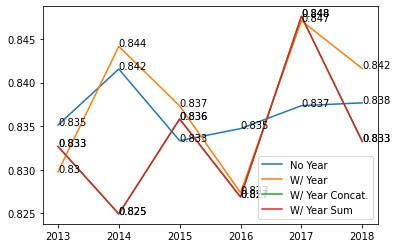

In [ ]:
accuracy_plot = {}

for year in correct:
  accuracy_plot[year] = correct[year] / total[year]

plt.plot(list(accuracy_plot.keys()), list(accuracy_plot.values()), label='No Year')

for year in accuracy_plot:
  plt.text(year, accuracy_plot[year], str(np.around(accuracy_plot[year], decimals=3)))

accuracy_plot_year = {}

for year in correct_year:
  accuracy_plot_year[year] = correct_year[year] / total[year]

plt.plot(list(accuracy_plot_year.keys()), list(accuracy_plot_year.values()), label='W/ Year')
for year in accuracy_plot_year:
  plt.text(year, accuracy_plot_year[year], str(np.around(accuracy_plot_year[year], decimals=3)))

accuracy_plot_year_concat = {}

for year in correct_year_concat:
  accuracy_plot_year_concat[year] = correct_year_concat[year] / total[year]

plt.plot(list(accuracy_plot_year_concat.keys()), list(accuracy_plot_year_concat.values()), label='W/ Year Concat.')
for year in accuracy_plot_year_concat:
  plt.text(year, accuracy_plot_year_concat[year], str(np.around(accuracy_plot_year_concat[year], decimals=3)))

accuracy_plot_year_sum = {}

for year in correct_year_sum:
  accuracy_plot_year_sum[year] = correct_year_sum[year] / total[year]

plt.plot(list(accuracy_plot_year_sum.keys()), list(accuracy_plot_year_sum.values()), label='W/ Year Sum')
for year in accuracy_plot_year_concat:
  plt.text(year, accuracy_plot_year_sum[year], str(np.around(accuracy_plot_year_sum[year], decimals=3)))



plt.legend()

plt.show()

In [ ]:
import gensim
import gensim.downloader as gensim_api

w2v = gensim_api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
all_train_text_w2v = train_data['reviewText']
stop_words = set(nltk.corpus.stopwords.words('english'))
clean_text_w2v = []
for x in all_train_text_w2v:
  #unigrams
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]
  clean_text_w2v.append(tokens)



filtered_text_w2v = []
for text in clean_text_w2v:
  text = [w for w in text if w in w2v.vocab]
  filtered_text_w2v.append(text)

In [ ]:
all_test_text_w2v = test_data['reviewText']

clean_text_w2v = []
for x in all_test_text_w2v:
  x = x.lower()
  tokens = x.split()

  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]

  #remove stopwords
  tokens = [w for w in tokens if not w in stop_words]
  clean_text_w2v.append(tokens)

filtered_text_test_w2v = []
for text in clean_text_w2v:
  text = [w for w in text if w in w2v.vocab]
  filtered_text_test_w2v.append(text)

In [ ]:
# embeddings = np.empty([len(train_data), 250, 100])

# row_counter = 0
# for text in filtered_text_w2v:
#   column_counter = 0
#   for i in range(len(text)):
#     embedding = w2v[str(text[i])]
#     embeddings[row_counter][column_counter] = embedding
#     column_counter += 1
#     if column_counter == 250:
#       break
#   row_counter += 1
# print(embeddings[:10])
# print(embeddings.shape)


train_indicies = np.empty([len(filtered_text_w2v), max_len])
for i in range(len(filtered_text_w2v)):
  text = filtered_text_w2v[i]
  entry = np.empty(max_len)
  for j in range(max_len):
    if j >= len(text):
      entry[j] = 0
    else: 
      word = text[j]
      entry[j] = w2v.wv.vocab[word].index
  train_indicies[i] = entry

print(type(train_indicies))
print(train_indicies[:5])
embedding_layer_w2v = w2v.get_keras_embedding()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


<class 'numpy.ndarray'>
[[5.47200e+04 9.40000e+01 4.23600e+03 2.09610e+04 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 

In [ ]:
# embeddings_test = np.empty([len(test_data), 250, 100])

# row_counter = 0
# for text in filtered_text_test_w2v:
#   column_counter = 0
#   for i in range(len(text)):
#     embedding = w2v[str(text[i])]
#     embeddings_test[row_counter][column_counter] = embedding
#     column_counter += 1
#     if column_counter == 250:
#       break
#   row_counter += 1


test_indicies = np.empty([len(filtered_text_test_w2v), max_len])
for i in range(len(filtered_text_test_w2v)):
  text = filtered_text_test_w2v[i]
  entry = np.empty(max_len)
  for j in range(max_len):
    if j >= len(text):
      entry[j] = 0
    else: 
      word = text[j]
      entry[j] = w2v.wv.vocab[word].index
  test_indicies[i] = entry

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
# input_text = tf.keras.layers.Input(shape=(max_len,))
# input_year = tf.keras.layers.Input(shape=(1,))
# embedding_text = embedding_layer_w2v(input_text)
# embedding_year = Embedding(7, 96, name='embedding_layer_year')(input_year)
# conv_size_8 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_8', padding='same')(embedding_text)
# conv_size_4 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_4', padding='same')(embedding_text)
# conv_size_2 = Conv1D(filters=32, kernel_size=8, activation='relu', name='convolutional_layer_2', padding='same')(embedding_text)
# pooling_8 = MaxPooling1D(pool_size=max_len, name='pooling_8')(conv_size_8)
# pooling_4 = MaxPooling1D(pool_size=max_len, name='pooling_4')(conv_size_4)
# pooling_2 = MaxPooling1D(pool_size=max_len, name='pooling_2')(conv_size_2)
# concat = tf.keras.layers.concatenate([pooling_8, pooling_4, pooling_2], axis=2, name='concatenation')
# flatten_text = Flatten(name='flattening_text')(concat)
# flatten_year = Flatten(name='flattening_year')(embedding_year)
# concat_year = tf.keras.layers.concatenate([flatten_text, flatten_year], axis=1, name='join_year')
# dense = Dense(10, activation='relu', name='hidden_layer')(concat_year)
# output = Dense(1, activation='sigmoid', name='output_layer')(dense)

# model_year_w2v = tf.keras.Model(inputs=[input_text, input_year], outputs=output)
# print(model_year_w2v.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 100)      40000000    ['input_7[0][0]']                
                                                                                                  
 convolutional_layer_8 (Conv1D)  (None, 80, 32)      25632       ['embedding[0][0]']              
                                                                                                  
 convolutional_layer_4 (Conv1D)  (None, 80, 32)      25632       ['embedding[0][0]']              
                                                                                            

In [ ]:
logdir="/content/gdrive/My Drive/large_CNN_w2v/logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model_year_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_year_w2v.fit([train_indicies, year_tokens], train_sentiment, epochs=10, callbacks=[tensorboard_callback])
# model_year_w2v.save("/content/gdrive/My Drive/large_CNN_w2v/model")

Epoch 1/10
1500/1500 [==============================] - 71s 47ms/step - loss: 0.4414 - accuracy: 0.7923
Epoch 2/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.3427 - accuracy: 0.8508
Epoch 3/10
1500/1500 [==============================] - 69s 46ms/step - loss: 0.2727 - accuracy: 0.8869
Epoch 4/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.2106 - accuracy: 0.9164
Epoch 5/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.1611 - accuracy: 0.9377
Epoch 6/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.1279 - accuracy: 0.9510
Epoch 7/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.1097 - accuracy: 0.9584
Epoch 8/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0971 - accuracy: 0.9621
Epoch 9/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0915 - accuracy: 0.9641
Epoch 10/10
1500/1500 [==============================] - 70s 47m

In [ ]:
# %tensorboard --logdir "/content/gdrive/My Drive/large_CNN_w2v/logs/"

In [ ]:
model_loaded_year_w2v = tf.keras.models.load_model('/content/gdrive/My Drive/large_CNN_w2v/model')
loss, accuracy = model_loaded_year_w2v.evaluate([test_indicies, test_year_tokens], test_sentiment)
print(accuracy * 100)

375/375 [==============================] - 8s 20ms/step - loss: 0.8173 - accuracy: 0.8202
82.02499747276306


In [ ]:
print(vocab_size)
w2v_vocab = set(w2v.vocab.keys())
print(len(w2v_vocab.intersection(vocab)))

21413
18748


TODO

* Look into layers and see why the accuracy drops
* hold out one year of data and see what happens there
* Try with word2vec to extract better cosine similarity


* only one signal provided in one filter
* No concept of context here
* add year as its own embedding to the flattened vector
* send into BERT year and the text separately. 